In [594]:
using LinearAlgebra
using Plots
using MultivariateStats#, StatsPlots
using Distributions
using DelimitedFiles
using DataFrames
using CSV
using ProgressMeter
using Profile

# Unscented Kalman Filtering on a Kinematic Bicycle

## Helper Functions

In [595]:
# f, Kinematic bicycle with teleporting steering
function dynamics(x, u, params)
    v, l = params
    px, py, θ = x
    δ = u[1]
    ẋ = [v*cos(θ);
         v*sin(θ);
         v*tan(δ) / l]
    return ẋ
end

dynamics (generic function with 1 method)

In [596]:
# Approximately integrate dynamics over a timestep dt to get a discrete update function
function rk4(xₖ, uₖ, params, dt)
    k1 = dynamics(xₖ, uₖ, params)
    k2 = dynamics(xₖ + k1*dt/2, uₖ, params)
    k3 = dynamics(xₖ + k2*dt/2, uₖ, params)
    k4 = dynamics(xₖ + k3*dt, uₖ, params)

    xₖ₊₁ = xₖ + dt * (k1 + 2k2 + 2k3 + k4) / 6
    return xₖ₊₁
end

rk4 (generic function with 1 method)

In [597]:
# Given a mean and covariance in N-dimensional space, generate 2N+1 weighted points
# with the given weighted mean and weighted covariance
function generate_sigma_points(x̂, Σ)
    Nx = length(x̂)
    A = sqrt(Σ)
    σ = [zeros(Nx) for j in 1:(2Nx+1)]
    W = zeros(2Nx+1)
    W[1] = 1/3

    σ[1] .= x̂

     for j in 1:Nx
        σ[1+j] .= @. x̂ + √(Nx / (1 - W[1])) * A[:,j] 
     end
 
     for j in 1:Nx
        σ[1+Nx+j] .= @. x̂ - √(Nx / (1 - W[1])) * A[:,j] 
     end
 
    W[2:end] .= (1- W[1])/(2Nx)
    
    return σ, W
end

generate_sigma_points (generic function with 1 method)

In [598]:
# maps vector in state space to vector in measurement space
# g, "GPS" measurement of positions
function measurement(x)
    y = x[1:2]
    return y
end

measurement (generic function with 1 method)

In [599]:
function accuracy_to_gps_noise!(R, accuracy)
  accuracy /= 1000.0
  σ = (accuracy / (0.848867684498)) * (accuracy / (0.848867684498))
  R .= [σ 0.0;
    0.0 σ]
end

accuracy_to_gps_noise! (generic function with 1 method)

## Predict and Update

In [600]:
# Given a state estimate and covariance, apply nonlinear dynamics over dt to sigma points
# and calculate a new state estimate and covariance
function ukf_predict(x̂ₖ, Σₖ, Q, uₖ, dt, params)
    Nx = length(x̂ₖ)
    σ, W = generate_sigma_points(x̂ₖ, Σₖ)

    for k in 1:lastindex(σ)
        σ[k] .= rk4(σ[k], uₖ, params, dt)
    end 

    x̂ₖ₊₁ = zeros(Nx)
    Σₖ₊₁ = zeros(Nx, Nx)

    for k in 1:lastindex(σ)
        x̂ₖ₊₁ .+= W[k].* σ[k]
    end
    for k in 1:lastindex(σ)
        Σₖ₊₁ .+= W[k].* ((σ[k] - x̂ₖ₊₁) * (σ[k] - x̂ₖ₊₁)')
    end

    Σₖ₊₁ .+= Q * dt

    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_predict (generic function with 1 method)

In [601]:
# Given a state estimate, covariance of the state estimate, measurement and covariance of the measurement,
# apply the measurement function to sigma points,
# calculate the mean and covariance in measurement space, then use this to calculate the Kalman gain, 
# then use the gain and measurement to calculate the updated state estimate and covariance.
function ukf_update(x̂, Σ, y, R)
    Nx = length(x̂)
    Ny = length(y)
    σ, W = generate_sigma_points(x̂, Σ)
    z = [zeros(Ny) for _ in σ]

    for j in 1:lastindex(σ)
        z[j] = measurement(σ[j])
    end 

    ẑ = zeros(Ny)
    S = zeros(Ny, Ny)
    Cxz = zeros(Nx, Ny)

    for k in 1:lastindex(z)
        ẑ .+= W[k].* z[k]
    end
    for k in 1:lastindex(z)
        S .+= W[k].* (z[k] - ẑ) * (z[k] - ẑ)'
        Cxz .+= W[k] .* (σ[k] - x̂) * (z[k] - ẑ)'
    end
    S .+= R

    K = Cxz * inv(S)

    x̂ₖ₊₁ = x̂ + K * (y - ẑ)
    Σₖ₊₁ = Σ - K * S * K'
    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_update (generic function with 1 method)

# Testing
using the filter on a simulated scenario

## Defining properties of the scenario
system parameters and covariances

In [602]:
# System parameters

l = 1.0 # Wheelbase, (m)
v = 0.0 # Velocity, (m/s)
params = v, l

(0.0, 1.0)

In [603]:
# Covariances. Remember, these are in squared units. To get an idea of the 
# corresponding 95% confidence interval, take the square root and multiply by ~2.

# Σ0 = diagm(ones(3)) # Initial estimate covariance for the filter
# Σ0 = diagm([1.5, 1.5, 1.5]) 
# Σ0 = diagm([3, 3, 3]) 
# Σ0 = zeros(3)
Σ0 = diagm([1e-4; 1e-4; 1e-6]) 

R = diagm([1e-2, 1e-2]) # Sensor covariances (m^2, m^2)
Q = diagm([1e-4; 1e-4; 1e-2]) # Process covariances (m^2, m^2, rad^2) 
                              # ^ the process covariances are timestep size dependent

3×3 Matrix{Float64}:
 0.0001  0.0     0.0
 0.0     0.0001  0.0
 0.0     0.0     0.01

## Loading Measurement and Input Data
gps, encoder, steering

In [604]:
run_name = "log130"
gps_df      = DataFrame(CSV.File("nand-logs/$run_name-gps.csv"))
encoder_df  = DataFrame(CSV.File("nand-logs/$run_name-encoder.csv"))
steering_df = DataFrame(CSV.File("nand-logs/$run_name-steering.csv"))
filter_df = DataFrame(CSV.File("nand-logs/$run_name-filter.csv"))
covar_df = DataFrame(CSV.File("nand-logs/$run_name-covar.csv"))


gps_df[!, "timestamp"] = gps_df[!, "timestamp"] ./ 1000.0           
encoder_df[!, "timestamp"] = encoder_df[!, "timestamp"] ./ 1000.0   
steering_df[!, "timestamp"] = steering_df[!, "timestamp"] ./ 1000.0 
filter_df[!, "timestamp"] = filter_df[!, "timestamp"] ./ 1000.0 
covar_df[!, "timestamp"] = covar_df[!, "timestamp"] ./ 1000.0 

C = hcat(covar_df[:, "c1"], covar_df[:, "c2"], covar_df[:, "c3"], covar_df[:, "c4"], covar_df[:, "c5"], covar_df[:, "c6"], covar_df[:, "c7"], covar_df[:, "c8"], covar_df[:, "c9"])
C = [reshape(C[k, :], (3,3)) for k in 1:size(C, 1)]


12002-element Vector{Matrix{Float64}}:
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
 ⋮
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.0e-6 -0.0 1.7e-5; -0.0 5.0e-6 -1.0e-6; 1.7e-5 -1.0e-6 0.002061]
 [5.

In [605]:
filter_df

12002×4 DataFrame
   Row │ timestamp  pos_x      pos_y      heading   
       │ Float64    Float64    Float64    Float64   
───────┼────────────────────────────────────────────
     1 │    11.023  0.0        0.0          3.14159
     2 │    11.027  0.0        0.0          3.14159
     3 │    11.029  0.0        0.0          3.14159
     4 │    11.032  0.0        0.0          3.14159
     5 │    11.036  0.0        0.0          3.14159
     6 │    11.039  0.0        0.0          3.14159
     7 │    11.042  0.0        0.0          3.14159
     8 │    11.045  0.0        0.0          3.14159
   ⋮   │     ⋮          ⋮          ⋮          ⋮
 11996 │    98.396  4.47746e6  5.89662e5  -52.2342
 11997 │    98.404  4.47746e6  5.89662e5  -52.2342
 11998 │    98.41   4.47746e6  5.89662e5  -52.2342
 11999 │    98.418  4.47746e6  5.89662e5  -52.2342
 12000 │    98.422  4.47746e6  5.89662e5  -52.2342
 12001 │    98.425  4.47746e6  5.89662e5  -52.2342
 12002 │    98.434  4.47746e6  5.89662e5  -52.2342
                                  11987 rows omitted

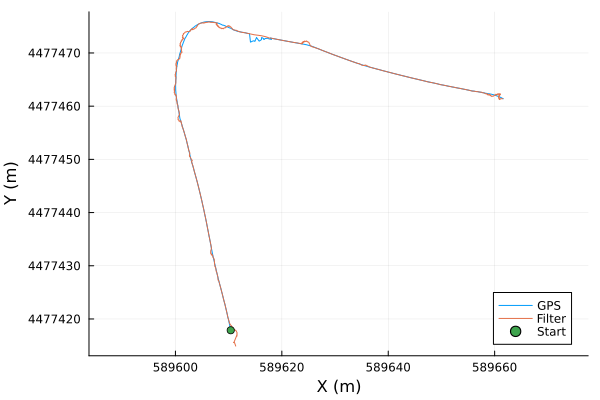

In [606]:
# Plot filtered and gps result from data
init_idx = findfirst(!isequal(0.0), filter_df[:, "pos_x"])+1
plot(aspect_ratio=:equal, xlabel="X (m)", ylabel="Y (m)")
plot!(gps_df[init_idx:end, "pos_y"], gps_df[init_idx:end, "pos_x"], label="GPS")
plot!(filter_df[init_idx:end, "pos_y"], filter_df[init_idx:end, "pos_x"], label="Filter")
scatter!(gps_df[init_idx:init_idx, "pos_y"], gps_df[init_idx:init_idx, "pos_x"], label="Start")

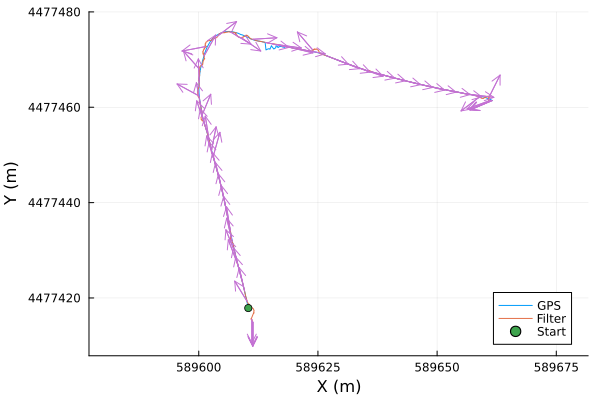

In [607]:
init_idx = findfirst(!isequal(0.0), filter_df[:, "pos_x"])+1
plot(aspect_ratio=:equal, xlabel="X (m)", ylabel="Y (m)")
plot!(gps_df[init_idx:end, "pos_y"], gps_df[init_idx:end, "pos_x"], label="GPS")
plot!(filter_df[init_idx:end, "pos_y"], filter_df[init_idx:end, "pos_x"], label="Filter")
scatter!(gps_df[init_idx:init_idx, "pos_y"], gps_df[init_idx:init_idx, "pos_x"], label="Start")
quiver!(filter_df[init_idx:200:end, "pos_y"], filter_df[init_idx:200:end, "pos_x"], quiver=(5sin.(filter_df[init_idx:200:end, "heading"]), 5cos.(filter_df[init_idx:200:end, "heading"])))

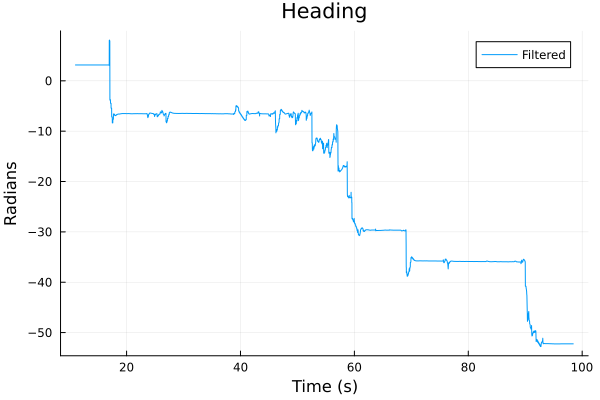

In [608]:
plot(filter_df[:, "timestamp"], filter_df[:, "heading"], title="Heading", ylabel="Radians", xlabel="Time (s)", label="Filtered")

In [609]:
covar_df[1:10, "c1"]

10-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

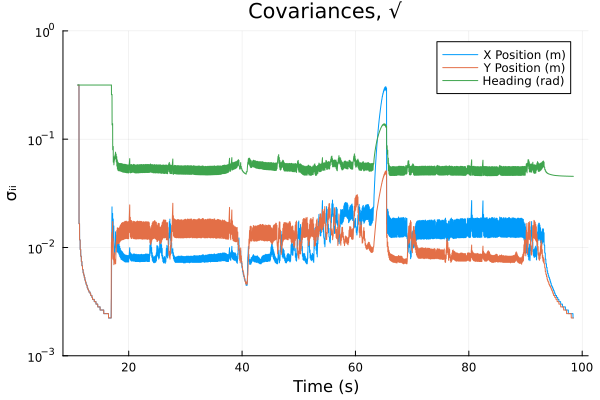

In [610]:
plot(title="Covariances, √", xlabel="Time (s)",  ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 1))
plot!(covar_df[:, "timestamp"], sqrt.(covar_df[:, "c1"]), label="X Position (m)")
plot!(covar_df[:, "timestamp"], sqrt.(covar_df[:, "c5"]), label="Y Position (m)")
plot!(covar_df[:, "timestamp"], sqrt.(covar_df[:, "c9"]), label="Heading (rad)")


In [611]:
# @show findlast(x -> x≈0.31622776601683794, sqrt.(covar_df[:, "c9"]))
covar_df[876:976, :]
# encoder_df[130:end, :]

101×10 DataFrame
 Row │ timestamp  c1        c2       c3         c4       c5        c6          ⋯
     │ Float64    Float64   Float64  Float64    Float64  Float64   Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    16.909  5.0e-6     0.0     -0.0        0.0     5.0e-6    -0.0        ⋯
   2 │    16.914  6.0e-6     0.0     -3.0e-6     0.0     7.0e-6    -0.000389
   3 │    16.917  6.0e-6     0.0     -1.0e-5     0.0     1.1e-5    -0.000685
   4 │    16.923  7.0e-6     0.0     -2.6e-5     0.0     2.0e-5    -0.001158
   5 │    16.928  7.0e-6     1.0e-6  -4.3e-5     1.0e-6  3.0e-5    -0.001522   ⋯
   6 │    16.936  9.0e-6     2.0e-6  -8.4e-5     2.0e-6  5.5e-5    -0.002188
   7 │    16.943  1.0e-5     4.0e-6  -0.000131   4.0e-6  8.8e-5    -0.002823
   8 │    16.95   1.1e-5     6.0e-6  -0.000177   6.0e-6  0.000125  -0.003414
  ⋮  │     ⋮         ⋮         ⋮         ⋮         ⋮        ⋮          ⋮       ⋱
  95 │    17.575  9.5e-5     8.0e-6   0.000294   8.0e-6  5.9e-5     2.1e-5     ⋯
  96 │    17.579  9.7e-5     8.0e-6   0.000311   8.0e-6  6.0e-5     1.1e-5
  97 │    17.592  7.5e-5     4.0e-6   0.000253   4.0e-6  5.0e-5    -1.1e-5
  98 │    17.604  8.8e-5     5.0e-6   0.000346   5.0e-6  5.1e-5     9.0e-6
  99 │    17.611  9.4e-5     6.0e-6   0.000384   6.0e-6  5.2e-5     1.7e-5     ⋯
 100 │    17.618  0.000101   7.0e-6   0.000423   7.0e-6  5.3e-5     2.5e-5
 101 │    17.625  0.000108   8.0e-6   0.000459   8.0e-6  5.4e-5     3.3e-5
                                                   3 columns and 86 rows omitted

## Running the UKF

In [612]:
# Simulate a non-deterministic process with process covariance Q and measurement covariance R,
# and with an Unscented Kalman Filter applied
function simulate_uk_filter(Q, R, gps_df, encoder_df, steering_df, l)
  gps_row = 1
  encoder_row = 1
  steering_row = 1

  gps_time = gps_df[!, "timestamp"]
  encoder_time = encoder_df[!, "timestamp"]
  steering_time = steering_df[!, "timestamp"]
  gps_accuracy = gps_df[!, "accuracy"]
  gps_pos_x = gps_df[!, "pos_x"]
  gps_pos_y = gps_df[!, "pos_y"]
  # steering = steering_df[:, "steering"]
  steering = deg2rad.(steering_df[:, "steering"])
  speed = encoder_df[!, "speed"]

  x̂ = [gps_df[1, "pos_x"]; gps_df[1, "pos_y"]; pi]
  Σ = diagm([0.1; 0.1; 0.1])
  Nk = size(gps_df, 1) + size(encoder_df, 1) + size(steering_df, 1)
  k = 1

  Xhat = [zeros(3) for k in 1:Nk]
  Sigma = [zeros(3, 3) for k in 1:Nk]
  t = zeros(Nk)
  tcur = 0.0

  v = 0.0

  last_predict_timestamp = min(gps_time[1], encoder_time[1], steering_time[1])

  while (gps_row <= size(gps_df, 1) && encoder_row <= size(encoder_df, 1) && steering_row <= size(steering_df, 1)) && gps_row < 1000

    if (last_predict_timestamp > gps_time[gps_row] && last_predict_timestamp > encoder_time[encoder_row] && last_predict_timestamp > steering_time[steering_row])
      continue
    end

    if (gps_time[gps_row] < encoder_time[encoder_row] && gps_time[gps_row] < steering_time[steering_row])
      # gps is the next timestamp
      # set the new gps noise
      # predict using most recent steering and velocity
      # then update using the current gps noise
      dt = gps_time[gps_row] - last_predict_timestamp

      accuracy_to_gps_noise!(R, gps_accuracy[gps_row])

      # if v > .9
        x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))
      # end

      x̂, Σ = ukf_update(x̂, Σ, [gps_pos_x[gps_row]; gps_pos_y[gps_row]], R)

      last_predict_timestamp = gps_time[gps_row]
      gps_row += 1
      tcur += dt
    elseif (encoder_time[encoder_row] < steering_time[steering_row])
      # encoder is the next timestamp
      # set the new speed stored by instance of UKF
      # predict using most recent steering and new speed
      dt = encoder_time[encoder_row] - last_predict_timestamp

      v = speed[encoder_row]
      # if v > .9
        x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))
      # end

      last_predict_timestamp = encoder_time[encoder_row]
      encoder_row += 1
      tcur += dt
    else
      # steering is the next timestamp
      # predict using this new steering
      dt = steering_time[steering_row] - last_predict_timestamp

      # if v > .9
        x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))
      # end

      last_predict_timestamp = steering_time[steering_row]
      steering_row += 1
      tcur += dt
    end


    Xhat[k] .= x̂
    Sigma[k] .= Σ
    t[k] = tcur
    k += 1
  end

  return t, Xhat, Sigma
end

simulate_uk_filter (generic function with 1 method)

In [613]:
@time t, Xhat, Sigma = simulate_uk_filter(Q, R, gps_df, encoder_df, steering_df, l)

  0.967512 seconds (4.38 M allocations: 190.236 MiB, 1.63% gc time, 88.34% compilation time)


([0.0, 0.0129999999999999, 0.023999999999999133, 0.03200000000000003, 0.03599999999999959, 0.04699999999999882, 0.05999999999999872, 0.07099999999999973, 0.07599999999999874, 0.08399999999999963  …  87.30499999999999, 87.317, 87.32799999999999, 87.34299999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [[4.477414910032e6, 589611.332367, 3.141592653589793], [4.477414910032e6, 589611.332367, 3.141592653589793], [4.477414910032e6, 589611.332367, 3.141592653589793], [4.477414909900646e6, 589611.3323670027, 3.14155167311186], [4.477414909834971e6, 589611.3323670061, 3.1415311828728933], [4.477414909654369e6, 589611.332367021, 3.1414880394311373], [4.47741490944094e6, 589611.332367047, 3.1414547712291965], [4.477414909260359e6, 589611.3323670733, 3.141439310839795], [4.477414909174708e6, 589611.3323670864, 3.1414385950113473], [4.477414909037669e6, 589611.3323671075, 3.1414374496858306]  …  [4.4774614104654435e6, 589661.5930464747, 7.453511534207889], [4.477461410466236e6, 589661.593048345, 7.4535115

In [614]:
Xhat

8654-element Vector{Vector{Float64}}:
 [4.477414910032e6, 589611.332367, 3.141592653589793]
 [4.477414910032e6, 589611.332367, 3.141592653589793]
 [4.477414910032e6, 589611.332367, 3.141592653589793]
 [4.477414909900646e6, 589611.3323670027, 3.14155167311186]
 [4.477414909834971e6, 589611.3323670061, 3.1415311828728933]
 [4.477414909654369e6, 589611.332367021, 3.1414880394311373]
 [4.47741490944094e6, 589611.332367047, 3.1414547712291965]
 [4.477414909260359e6, 589611.3323670733, 3.141439310839795]
 [4.477414909174708e6, 589611.3323670864, 3.1414385950113473]
 [4.477414909037669e6, 589611.3323671075, 3.1414374496858306]
 ⋮
 [4.477461410466236e6, 589661.593048345, 7.45351153420789]
 [4.4774614104669625e6, 589661.5930500592, 7.453511534207891]
 [4.47746141055917e6, 589661.592499486, 7.453421238502061]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

## Visualizations

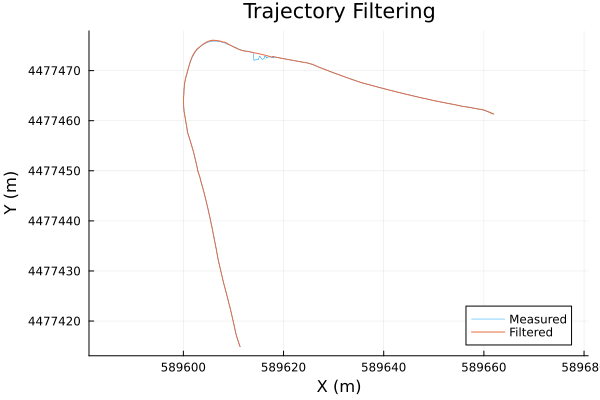

In [615]:
# Let's see how the filter does on position estimation

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!(gps_df[:, "pos_y"], gps_df[:, "pos_x"], label="Measured", linewidth=0.5)
plot!([x[2] for x in Xhat[1:(end-6)]], [x[1] for x in Xhat[1:(end-6)]], label="Filtered")
# quiver!([x[2] for x in Xhat[1:200:(end-6)]], [x[1] for x in Xhat[1:200:(end-6)]], quiver=(sin.([x[3] for x in Xhat[1:200:(end-6)]]), cos.([x[3] for x in Xhat[1:200:(end-6)]])))

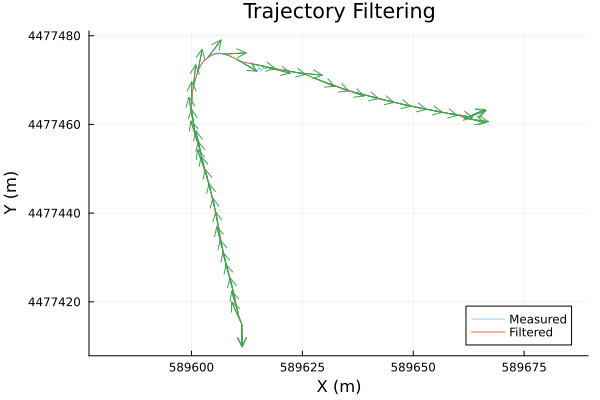

In [616]:
# Let's see how the filter does on position estimation

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!(gps_df[:, "pos_y"], gps_df[:, "pos_x"], label="Measured", linewidth=0.5)
plot!([x[2] for x in Xhat[1:(end-6)]], [x[1] for x in Xhat[1:(end-6)]], label="Filtered")
quiver!([x[2] for x in Xhat[1:200:(end-6)]], [x[1] for x in Xhat[1:200:(end-6)]], quiver=(5sin.([x[3] for x in Xhat[1:200:(end-6)]]), 5cos.([x[3] for x in Xhat[1:200:(end-6)]])))

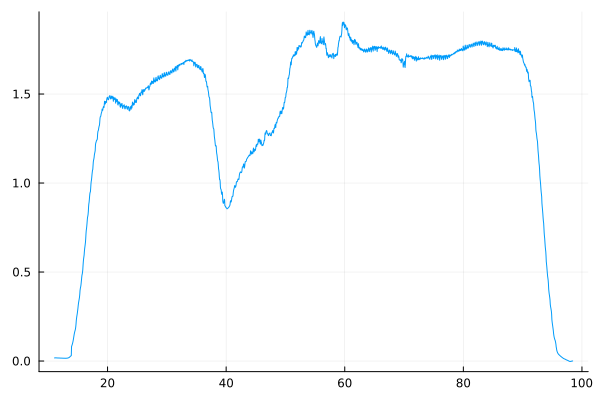

In [617]:
plot(encoder_df[!, "timestamp"], encoder_df[!, "speed"], label=nothing)

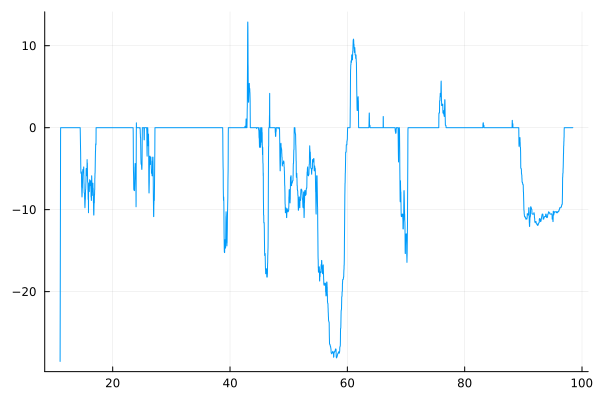

In [618]:
plot(steering_df[!, "timestamp"], steering_df[!, "steering"], label=nothing)

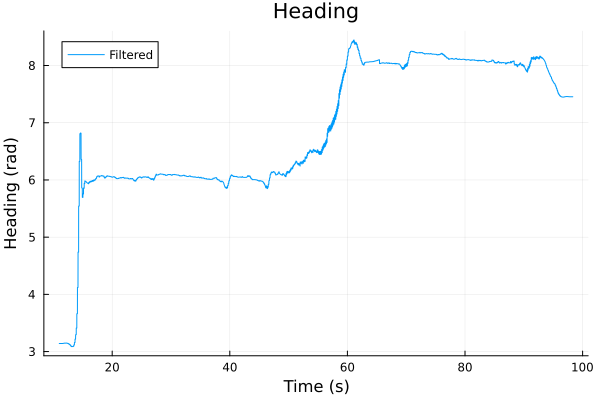

In [619]:
# Remember, we aren't measuring the heading, only a noisy position, 
# but the filter is able to use this information to converge to
# a good estimate of the heading over time.

plot(title="Heading", xlabel="Time (s)", ylabel="Heading (rad)")
# plot!(t, [x[3] for x in X], label="True")
plot!((t.+11)[1:(end-7)], [x[3] for x in Xhat][1:(end-7)], label="Filtered")#, color="green")

In [620]:
hcat((t.+11)[105:end], [√(σ²[1,1]) for σ² in Sigma][105:end])

8550×2 Matrix{Float64}:
 11.973  0.00765489
 11.984  0.00772643
 11.985  0.0077329
 12.001  0.00783571
 12.015  0.00792457
 12.025  0.00719841
 12.032  0.00724688
 12.033  0.00725377
 12.049  0.00736328
 12.063  0.00745777
  ⋮      
 98.317  0.00749472
 98.328  0.00756775
 98.343  0.00696063
 11.0    0.0
 11.0    0.0
 11.0    0.0
 11.0    0.0
 11.0    0.0
 11.0    0.0

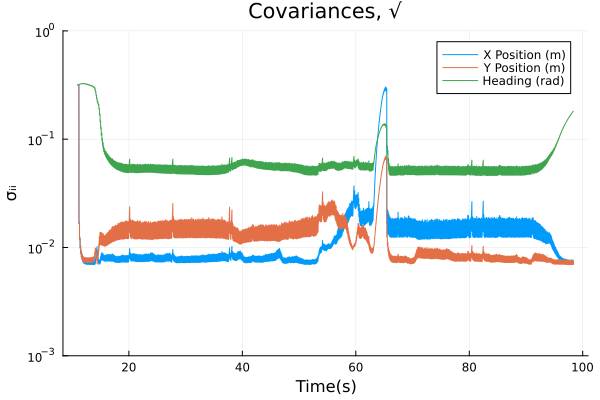

In [621]:
# And let's see how the filter's confidence in its estimate evolves over time

plot(title="Covariances, √", xlabel="Time(s)", ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 1))
plot!(t.+11., [√(σ²[1,1]) for σ² in Sigma], label="X Position (m)")
plot!(t.+11., [√(σ²[2,2]) for σ² in Sigma], label="Y Position (m)")
plot!(t.+11., [√(σ²[3,3]) for σ² in Sigma], label="Heading (rad)")

In [622]:
any([minimum(values) for (values,vectors) in eigen.(Sigma)] .< 0)

false

In [623]:
any([minimum(values) for (values,vectors) in eigen.(C)] .< 0)

false